In [25]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config
import pickle
import os


Load pre-generated TDM based on neural network trained based on real world bags. Load two different TDMs---one "ground truth" and the other one is robot's prediction. Robot can used the associated GMM confidence score to rule out region with low confidence.

Desired results (since we've swept through alpha and different algorithms, here we focus on the effect of GMM-based outlier detection.) Choose a single planner and a single parameter (e.g., full distribution, use CVaR(alpha=0.8) and 1024 control sequence of 1024 environment samples. Since number of environment samples are fewer, we use higher alpha values.)
* Choose two test maps, each map with a single pair of (start, goal)
* Adjust the confidence threshold (e.g. [0.1, 0.3, 0.5, 0.7, 0.9]) ==> report infeasible if goal is not reached for all trials
* Report success rate with random realizations of the map given ground truth
* Report the time-to-goal


In [26]:
# wp_forest2 and fells_nn are both good (there's some problem with wp_forest1 to be fixed)

# trained_folder = "tdm_models/predicted"
# trained_model_subfolder = "wp_forest2_predicts_fells_nn"
# gt_folder = "tdm_models/ground_truth" # "tdm_models/ground_truth"
# gt_model_subfolder = "fells_nn"

trained_folder = "tdm_models/predicted"
trained_model_subfolder = "fells_nn_predicts_wp_forest1"
gt_folder = "tdm_models/ground_truth" # "tdm_models/ground_truth"
gt_model_subfolder = "wp_forest1"
# -----------------------------------------------------------------


with open(os.path.join(trained_folder, trained_model_subfolder, "tdm_info.pickle" ), 'rb') as fh:
  pred_tdm_info = pickle.load(fh)
  print(pred_tdm_info.keys())

with open(os.path.join(gt_folder, gt_model_subfolder, "tdm_info.pickle"), 'rb') as fh:
  gt_tdm_info = pickle.load(fh)


id2rgb_map = gt_tdm_info['id2rgb_map']
rgb2id_map = gt_tdm_info['rgb2id_map']
id2rgb_map[-1] = (0,0,0)
rgb2id_map[(0,0,0)] = -1
id2rgb_map = {k: np.array(v)/255 for k, v in id2rgb_map.items()}
rgb2id_map = {np.array(v)/255: v for k, v in rgb2id_map.items()}
w = gt_tdm_info['width']
h = gt_tdm_info['height']

# TODO: only visualize partially based on known areas
semantic_grid = gt_tdm_info['color_indices'] 

# For places where we don't have access to ground truth, also mask away the same region in the predicted map.
gt_unknown = gt_tdm_info["unknown_colors_mask"]
pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
# Adjust the PMF
pred_tdm_info["lin_pmf_grid"][0,gt_unknown] = 100
pred_tdm_info["lin_pmf_grid"][1:,gt_unknown] = 0
pred_tdm_info["ang_pmf_grid"][0,gt_unknown] = 100
pred_tdm_info["ang_pmf_grid"][1:,gt_unknown] = 0
# For places where ground truth is 0 traction, we mask away the predicted map as well
gt_no_traction_mask = gt_tdm_info["lin_pmf_grid"][0,:,:]==100
pred_tdm_info["lin_pmf_grid"][0,gt_no_traction_mask]=100
pred_tdm_info["lin_pmf_grid"][1:,gt_no_traction_mask]=0
pred_tdm_info["ang_pmf_grid"][0,gt_no_traction_mask]=100
pred_tdm_info["ang_pmf_grid"][1:,gt_no_traction_mask]=0

dict_keys(['xlimits', 'ylimits', 'res', 'bin_values', 'bin_values_bounds', 'height', 'width', 'lin_pmf_grid', 'ang_pmf_grid', 'normalized_confidence', 'color_indices', 'color_mask', 'unknown_colors_mask', 'elevation', 'id2rgb_map', 'rgb2id_map'])


In [27]:
# Can generate the TDM object

def reset_tdm_from_info(lin_tdm, ang_tdm, tdm_info, alpha_dyn, obstacle_map=None, unknown_map=None):

  tdm_params = {
    "xlimits": tdm_info['xlimits'],
    "ylimits": tdm_info['ylimits'],
    "res": tdm_info['res'],
    "bin_values": tdm_info['bin_values'],
    "bin_values_bounds": tdm_info['bin_values_bounds'],
    "det_dynamics_cvar_alpha": alpha_dyn,
  }
  
  lin_tdm.reset()
  ang_tdm.reset()
  lin_tdm.set_TDM_from_PMF_grid(tdm_info['lin_pmf_grid'], tdm_params, obstacle_map=obstacle_map, unknown_map=unknown_map)
  ang_tdm.set_TDM_from_PMF_grid(tdm_info['ang_pmf_grid'], tdm_params, obstacle_map=obstacle_map, unknown_map=unknown_map)



max_speed = 1.0
use_tdm = True # True # True
use_det_dynamics = False # True
use_nom_dynamics_with_speed_map = False # 
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024, # 5*1024, #1024,
  num_control_rollouts = 1024,
  max_speed_padding = max_speed+2.0,
  num_vis_state_rollouts = 100,
  max_map_dim =(150, 100),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)


gt_lin_tdm = TDM_Numba(cfg)
gt_ang_tdm = TDM_Numba(cfg)
pred_lin_tdm = TDM_Numba(cfg)
pred_ang_tdm = TDM_Numba(cfg)
mppi_planner = MPPI_Numba(cfg)


# ------------- Problem configuration ------------




x0=np.array([7.0, 52.0])
xgoal= np.array([40, 20])

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,

    # For risk-aware min time planning
    goal_tolerance=1.0,
    v_post_rollout=0.01,
    cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
    alpha_dyn=1.0, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

    dist_weight=0,

    # Hyper parameters
    lambda_weight=0.3,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 3.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0.0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)



reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'])
reset_tdm_from_info(pred_lin_tdm, pred_ang_tdm, pred_tdm_info, mppi_params['alpha_dyn'])

# Visualize the grimap with colors

TDM has initialized GPU memory after 0.06347346305847168 s
TDM has initialized GPU memory after 0.04096627235412598 s
TDM has initialized GPU memory after 0.04142355918884277 s
TDM has initialized GPU memory after 0.04074811935424805 s
MPPI planner has initialized GPU memory after 0.016055583953857422 s


In [21]:
def sample_traction_grid(lin_tdm, ang_tdm, h, w):
  # TODO: need to get padded xlimits and padded width and height
  # Sample a specific map from the ground truth distribution
  lin_traction_grid_int8 = lin_tdm.sample_grids().copy_to_host()[0]
  lin = lin_traction_grid_int8*(lin_tdm.bin_values_bounds[1]-lin_tdm.bin_values_bounds[0])/100.0+lin_tdm.bin_values_bounds[0]

  ang_traction_grid_int8 = ang_tdm.sample_grids().copy_to_host()[0]
  ang = ang_traction_grid_int8*(ang_tdm.bin_values_bounds[1]-ang_tdm.bin_values_bounds[0])/100.0+ang_tdm.bin_values_bounds[0]

  res = lin_tdm.res
  return TractionGrid(lin, ang, res, use_int8=False, xlimits=lin_tdm.padded_xlimits, ylimits=lin_tdm.padded_ylimits)  


def visualize_useful_info(lin_tdm, ang_tdm, gt_tdm_info, pred_tdm_info, h, w, figsize=(5,5)):


  lin_tdm_vis = TDM_Visualizer(lin_tdm, tdm_contains_semantic_grid=False)
  ang_tdm_vis = TDM_Visualizer(ang_tdm, tdm_contains_semantic_grid=False)

  # Visualize the semantics
  fig, ax = lin_tdm_vis.draw(figsize=figsize, semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)

  # # Visualize the height map
  # fig, ax = plt.subplots()
  # # lin = traction_grid.lin_traction
  # img = ax.imshow(gt_tdm_info['elevation'], origin='lower', vmin=0, vmax=1.0, cmap='gray')
  # ax.set_title('elevation')
  # divider = make_axes_locatable(ax)
  # cax = divider.append_axes("right", size="5%", pad=0.05)
  # plt.colorbar(img, cax=cax)
  # plt.show()



  # Sample a specific map from the distribution that can be used to update the robot state
  traction_grid = sample_traction_grid(lin_tdm, ang_tdm, h, w)
  lin = traction_grid.lin_traction
  ang = traction_grid.ang_traction
  fig, ax = plt.subplots(figsize=figsize)
  # lin = traction_grid.lin_traction
  img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
  ax.set_title('sampled linear traction')
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(img, cax=cax)
  plt.show()

  fig, ax = plt.subplots(figsize=figsize)
  img = ax.imshow(pred_tdm_info['unknown_colors_mask'], origin='lower', vmin=0, vmax=1.0, cmap='gray')
  ax.set_title("predictor's unknown color mask")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(img, cax=cax)
  plt.show()

  fig, ax = plt.subplots(figsize=figsize)
  img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
  ax.set_title('sampled angular traction')
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(img, cax=cax)
  plt.show()

  # Likelihood score plot with heatmap
  fig, ax = plt.subplots(figsize=figsize)
  # lin = traction_grid.lin_traction
  img = ax.imshow(pred_tdm_info['normalized_confidence'], origin='lower', vmin=0, vmax=1.0, cmap='gray', alpha=1.0)
  ctr = ax.contourf(pred_tdm_info['normalized_confidence'],
                   levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                  # levels=[0.0, 0.3, 0.6, 1.0], 
                  #  cmap="YlOrRd_r",
                  cmap="Reds_r",
                  #  cmap="viridis",
                  alpha=0.9, antialiased=True)
  ax.set_title("Predictor's Confidence Score")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  # plt.colorbar(img, cax=cax)
  plt.colorbar(ctr, cax=cax)
  plt.show()

  # # Visualize the goal
  # # Likelihood score plot with heatmap
  # fig, ax = plt.subplots()
  # # lin = traction_grid.lin_traction
  # img = ax.imshow(gt_tdm_info['normalized_confidence'], origin='lower', vmin=0, vmax=1.0, cmap='gray', alpha=1.0)
  # ctr = ax.contourf(gt_tdm_info['normalized_confidence'],
  #                 #  levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
  #                 levels=[0.0, 0.3, 0.6, 1.0], 
  #                 #  cmap="YlOrRd_r",
  #                 cmap="Reds_r",
  #                 #  cmap="viridis",
  #                 alpha=0.9, antialiased=True)
  # ax.scatter([x0[0]], [x0[1]], c='white', s=50)
  # c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal", zorder=6)
  # ax.add_patch(c1)
  # # ax.scatter([xgoal[0]], [xgoal[1]], c='white', s=50, filled=False)
  # ax.set_title('Confidence Score')
  # divider = make_axes_locatable(ax)
  # cax = divider.append_axes("right", size="5%", pad=0.05)
  # # plt.colorbar(img, cax=cax)
  # plt.colorbar(ctr, cax=cax)
  # plt.show()

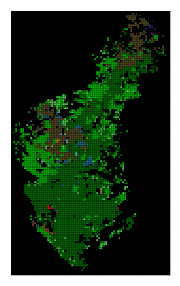

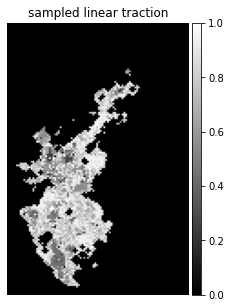

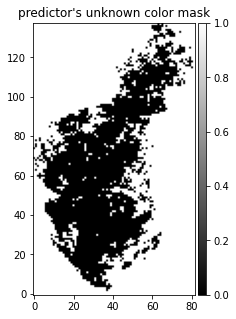

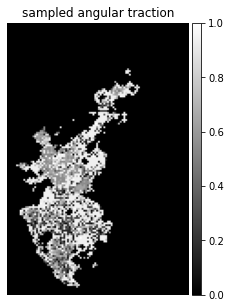

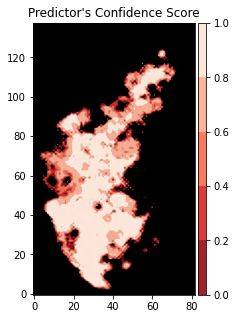

In [22]:
visualize_useful_info(pred_lin_tdm, pred_ang_tdm,  gt_tdm_info, pred_tdm_info, h, w)
# visualize_useful_info(gt_lin_tdm, gt_ang_tdm,  gt_tdm_info, gt_tdm_info, h, w)

[-2. 39.]
[-22.5  46.5]


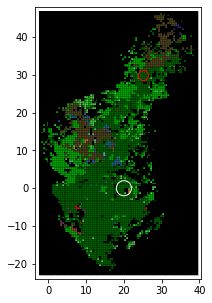

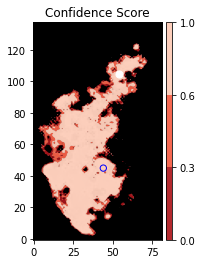

In [23]:
# Try to plot the start and end first 
x0=np.array([25, 30, 0])
xgoal= np.array([20, 0])

# x0=np.array([25, 30, -np.pi/4*3])
# xgoal= np.array([15, 0])

# x0=np.array([10, 10, 0])
# xgoal= np.array([20, 0])
goal_tolerance=2.0
print(pred_tdm_info['xlimits'])
print(pred_tdm_info['ylimits'])


mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,

    # For risk-aware min time planning
    goal_tolerance=goal_tolerance,
    v_post_rollout=0.1,
    cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
    alpha_dyn=1.0, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

    dist_weight=1.0,

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 3.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0.0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

lin_tdm_vis = TDM_Visualizer(gt_lin_tdm, tdm_contains_semantic_grid=False)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5), semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)
ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='w', fill=False, label="Goal", zorder=6)
ax.add_patch(c1)
plt.axis("on")

fig, ax = plt.subplots()
img = ax.imshow(pred_tdm_info['normalized_confidence'], origin='lower', vmin=0, vmax=1.0, cmap='gray', alpha=1.0)
ctr = ax.contourf(pred_tdm_info['normalized_confidence'],
                #  levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                levels=[0.0, 0.3, 0.6, 1.0], 
                #  cmap="YlOrRd_r",
                cmap="Reds_r",
                #  cmap="viridis",
                alpha=0.9, antialiased=True)
hm_x0 = copy.deepcopy(x0)
hm_xgoal = copy.deepcopy(xgoal)
hm_x0[0] = (hm_x0[0] - gt_lin_tdm.xlimits[0])/gt_lin_tdm.res
hm_x0[1] = (hm_x0[1] - gt_lin_tdm.ylimits[0])/gt_lin_tdm.res
hm_xgoal[0] = (hm_xgoal[0] - gt_lin_tdm.xlimits[0])/gt_lin_tdm.res
hm_xgoal[1] = (hm_xgoal[1] - gt_lin_tdm.ylimits[0])/gt_lin_tdm.res

ax.scatter([hm_x0[0]], [hm_x0[1]], c='white', s=50)
c1 = plt.Circle(hm_xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal", zorder=6)
ax.add_patch(c1)
# ax.scatter([xgoal[0]], [xgoal[1]], c='white', s=50, filled=False)
ax.set_title('Confidence Score')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(img, cax=cax)
plt.colorbar(ctr, cax=cax)
plt.show()


TDM has initialized GPU memory after 0.04302191734313965 s
TDM has initialized GPU memory after 0.04120898246765137 s
TDM has initialized GPU memory after 0.04003500938415527 s
TDM has initialized GPU memory after 0.0417325496673584 s
MPPI planner has initialized GPU memory after 0.01599407196044922 s


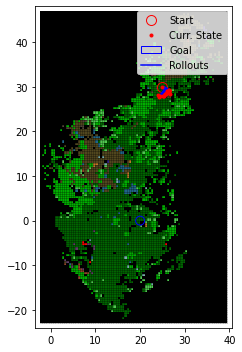

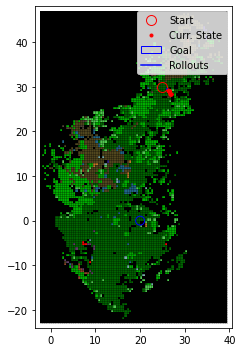

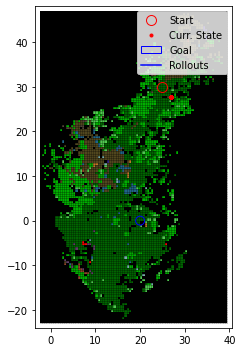

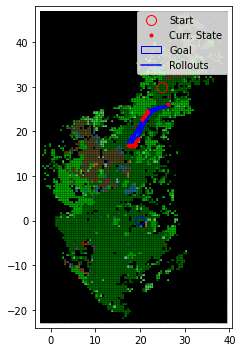

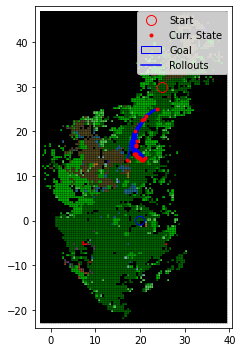

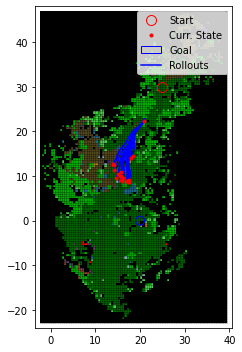

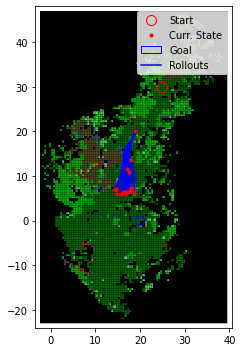

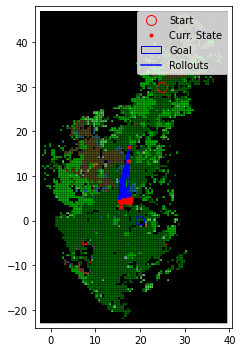

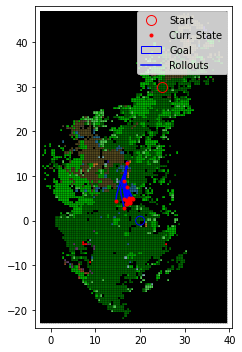

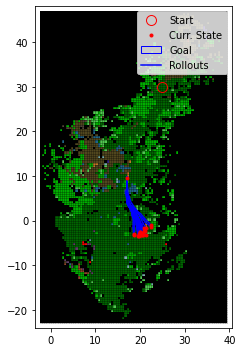

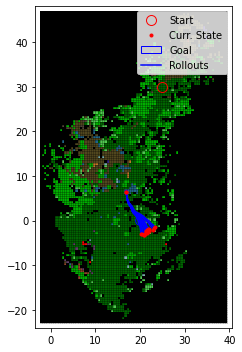

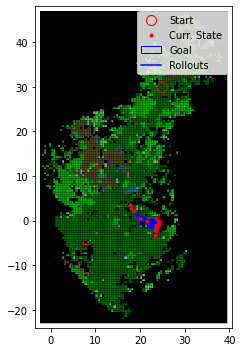

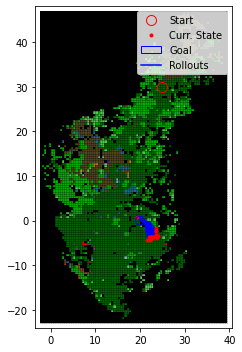

goal reached at t=244


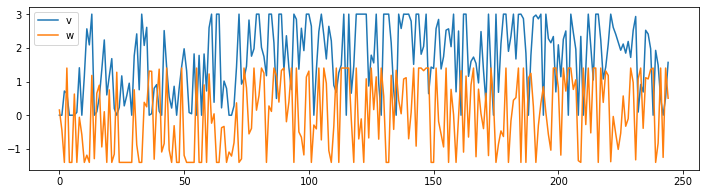

In [9]:
max_speed = 3 # 1.0
max_angular = 1.4
use_tdm = True# True # True
use_det_dynamics = False # True
use_nom_dynamics_with_speed_map = False # 
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024, # 5*1024, #1024,
  num_control_rollouts = 1024,
  max_speed_padding = max_speed+2.0,
  num_vis_state_rollouts = 20,
  max_map_dim =(150, 150),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)


gt_lin_tdm = TDM_Numba(cfg)
gt_ang_tdm = TDM_Numba(cfg)
pred_lin_tdm = TDM_Numba(cfg)
pred_ang_tdm = TDM_Numba(cfg)
mppi_planner = MPPI_Numba(cfg)


# ------------- Problem configuration ------------
# x0=np.array([7.0, 52.0])
# xgoal= np.array([40, 20])

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,

    # For risk-aware min time planning
    goal_tolerance=1.0,
    v_post_rollout=0.01,
    cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
    alpha_dyn=1.0, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

    dist_weight=1.0,

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([1.0, 1.5]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0.0, max_speed]), 
    wrange=np.array([-max_angular, max_angular]),
)



# Construct the MPPI planner + initialize the GPU variables
gt_lin_tdm.reset()
gt_ang_tdm.reset()
pred_lin_tdm.reset()
pred_ang_tdm.reset()
mppi_planner.reset()
obstacle_map = None # 
unknown_map = np.zeros(semantic_grid.shape, dtype=np.int8) 
unknown_map[semantic_grid==-1] = 1
# obstacle_map[semantic_grid==-1] = 1

# Use the outlier detection threshold 
confidence_thres = 0.1
unknown_map[pred_tdm_info["normalized_confidence"] < confidence_thres] = 1
# obstacle_map[pred_tdm_info["normalized_confidence"] < confidence_thres] = 1

reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'], obstacle_map=obstacle_map, unknown_map=unknown_map)
reset_tdm_from_info(pred_lin_tdm, pred_ang_tdm, pred_tdm_info, mppi_params['alpha_dyn'], obstacle_map=obstacle_map, unknown_map=unknown_map)

mppi_planner.setup(mppi_params, pred_lin_tdm, pred_ang_tdm)


# Firstly, sample traction from the GROUNDTRUTH!
traction_grid = sample_traction_grid(gt_lin_tdm, gt_ang_tdm, h, w)


# Loop
# max_steps = 151
max_steps = 301
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

plot_every_n = 20
# plot_every_n = 1
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  # assert lt!=0, "t={}, lt={}, at={}".format(t, lt, at)
  # assert at!=0, "t={}, lt={}, at={}".format(t, lt, at)
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


  if t%plot_every_n==0:
    lin_tdm_vis = TDM_Visualizer(gt_lin_tdm, tdm_contains_semantic_grid=False)
    fig, ax = lin_tdm_vis.draw(figsize=(5, 5), semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)
    ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ro', markersize=3, label="Curr. State", zorder=5)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal", zorder=6)
    ax.add_patch(c1)
    plt.axis("on")
    # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    
    # ax.plot(xhist[:,0], xhist[:,1], 'r', label="Past State")
    # sc = ax.scatter(xhist[1:t+1,0], xhist[1:t+1,1], c=np.linalg.norm(uhist[:t], axis=1), cmap='hot')
    # sc = ax.scatter(xhist[1:t+1,0], xhist[1:t+1,1], c=np.abs(uhist[:t, 0]), cmap='hot')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(sc, cax=cax)
    
    ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b', zorder=3)
    ax.plot(rollout_states_vis[0,:,0], rollout_states_vis[0,:,1], 'b', label="Rollouts")
    ax.legend()
    plt.tight_layout()
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  
  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={}".format(t))
    break



fig, ax = plt.subplots(figsize=(12,3))
ax.plot(uhist[:,0], label='v')
ax.plot(uhist[:,1], label='w')
ax.legend()
plt.show()

Visualize the resultant traction after masking away the predictions with low log likelihood score

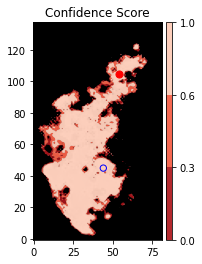

thres=0


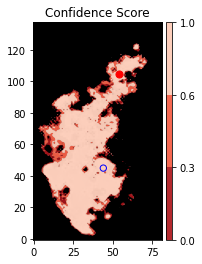

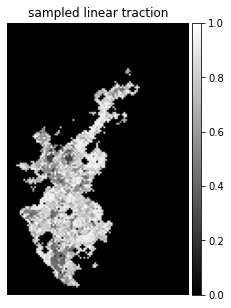

thres=0.3


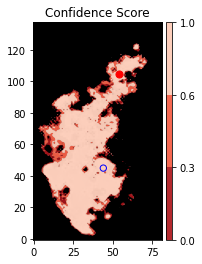

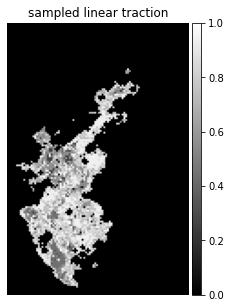

thres=0.6


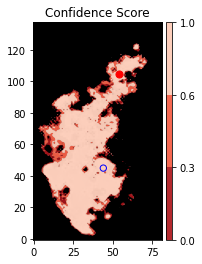

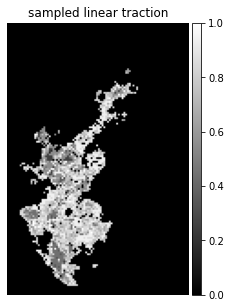

thres=0.9


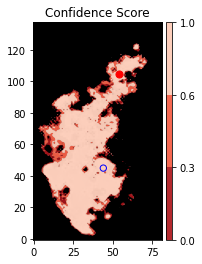

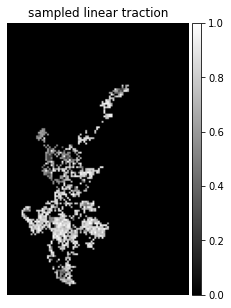

In [24]:
for thres in [0, 0.3, 0.6, 0.9]:
  print("thres={}".format(thres))
  modified_pred_tdm_info = copy.deepcopy(pred_tdm_info)
  # For places where we don't have access to ground truth, also mask away the same region in the predicted map.
  gt_unknown = gt_tdm_info["unknown_colors_mask"]
  modified_pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
  modified_pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
  # Adjust the PMF
  modified_pred_tdm_info["lin_pmf_grid"][0,gt_unknown] = 100
  modified_pred_tdm_info["lin_pmf_grid"][1:,gt_unknown] = 0
  modified_pred_tdm_info["ang_pmf_grid"][0,gt_unknown] = 100
  modified_pred_tdm_info["ang_pmf_grid"][1:,gt_unknown] = 0
  # For places where ground truth is 0 traction, we mask away the predicted map as well
  gt_no_traction_mask = gt_tdm_info["lin_pmf_grid"][0,:,:]==100
  modified_pred_tdm_info["lin_pmf_grid"][0,gt_no_traction_mask]=100
  modified_pred_tdm_info["lin_pmf_grid"][1:,gt_no_traction_mask]=0
  modified_pred_tdm_info["ang_pmf_grid"][0,gt_no_traction_mask]=100
  modified_pred_tdm_info["ang_pmf_grid"][1:,gt_no_traction_mask]=0

  # Mask away the tractions where confidence score is very low
  low_conf_mask = modified_pred_tdm_info["normalized_confidence"] < thres
  modified_pred_tdm_info["lin_pmf_grid"][0,low_conf_mask]=100
  modified_pred_tdm_info["lin_pmf_grid"][1:,low_conf_mask]=0
  modified_pred_tdm_info["ang_pmf_grid"][0,low_conf_mask]=100
  modified_pred_tdm_info["ang_pmf_grid"][1:,low_conf_mask]=0



  fig, ax = plt.subplots()
  img = ax.imshow(modified_pred_tdm_info['normalized_confidence'], origin='lower', vmin=0, vmax=1.0, cmap='gray', alpha=1.0)
  ctr = ax.contourf(modified_pred_tdm_info['normalized_confidence'],
                  #  levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                  levels=[0.0, 0.3, 0.6, 1.0], 
                  #  cmap="YlOrRd_r",
                  cmap="Reds_r",
                  #  cmap="viridis",
                  alpha=0.9, antialiased=True)
  hm_x0 = copy.deepcopy(x0)
  hm_xgoal = copy.deepcopy(xgoal)
  hm_x0[0] = (hm_x0[0] - gt_lin_tdm.xlimits[0])/gt_lin_tdm.res
  hm_x0[1] = (hm_x0[1] - gt_lin_tdm.ylimits[0])/gt_lin_tdm.res
  hm_xgoal[0] = (hm_xgoal[0] - gt_lin_tdm.xlimits[0])/gt_lin_tdm.res
  hm_xgoal[1] = (hm_xgoal[1] - gt_lin_tdm.ylimits[0])/gt_lin_tdm.res

  ax.scatter([hm_x0[0]], [hm_x0[1]], c='r', s=50)
  c1 = plt.Circle(hm_xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal", zorder=6)
  ax.add_patch(c1)
  # ax.scatter([xgoal[0]], [xgoal[1]], c='white', s=50, filled=False)
  ax.set_title('Confidence Score')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  # plt.colorbar(img, cax=cax)
  plt.colorbar(ctr, cax=cax)
  plt.show()


  # Update the lin_tdm and ang_tdm of the predicted version

  # Construct the MPPI planner + initialize the GPU variables
  obstacle_map = None # 
  unknown_map = np.zeros(semantic_grid.shape, dtype=np.int8) 
  unknown_map[semantic_grid==-1] = 1
  # obstacle_map[semantic_grid==-1] = 1

  # Use the outlier detection threshold 
  confidence_thres = 0.1
  unknown_map[pred_tdm_info["normalized_confidence"] < confidence_thres] = 1
  # obstacle_map[pred_tdm_info["normalized_confidence"] < confidence_thres] = 1

  reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'], obstacle_map=obstacle_map, unknown_map=unknown_map)
  reset_tdm_from_info(pred_lin_tdm, pred_ang_tdm, modified_pred_tdm_info, mppi_params['alpha_dyn'], obstacle_map=obstacle_map, unknown_map=unknown_map)
  mppi_planner.reset()
  mppi_planner.setup(mppi_params, pred_lin_tdm, pred_ang_tdm)


  # Firstly, sample traction from the GROUNDTRUTH!
  traction_grid = sample_traction_grid(gt_lin_tdm, gt_ang_tdm, h, w)


  traction_grid = sample_traction_grid(pred_lin_tdm, pred_ang_tdm, h, w)
  lin = traction_grid.lin_traction
  ang = traction_grid.ang_traction
  fig, ax = plt.subplots(figsize=(5,5))
  # lin = traction_grid.lin_traction
  img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
  ax.set_title('sampled linear traction')
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(img, cax=cax)
  plt.show()
